In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read the Database
data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/TheMotherLoad.csv')
# Turn Begin Date into DateTime
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
#Create Lags for All of the different renewables
data['wind_output_lag1'] = data['Wind'].shift(1)
data['nuclear_output_lag1'] = data['Nuclear'].shift(1)
data['hydro_output_lag1'] = data['Hydro'].shift(1)

In [4]:
# Year Before
# Subtract one year using pd.DateOffset instead of pd.Timedelta
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)

# Extract only renewable data for Hydro, Nuclear, and Wind
Renewable_data = data[['BeginDate', 'Hydro', 'Nuclear', 'Wind']].copy()

# Define a function to get the closest renewable data from the previous year
def get_previous_day_renewables(row, reference_df):
    # Find the closest entry to the 'Previous_Year' in the reference DataFrame
    closest_entry = reference_df.iloc[(reference_df['BeginDate'] - row['Previous_Year']).abs().argsort()[:1]]
    
    if not closest_entry.empty:
        # Return the corresponding renewable values (Hydro, Nuclear, Wind)
        return closest_entry[['Hydro', 'Nuclear', 'Wind']].values[0]
    return [None, None, None]  # Return None for each renewable tech if no match is found

In [5]:
train_data = data[
    (data['BeginDate'] >= '2023-10-01') & 
    (data['BeginDate'] <= '2024-10-01')
]
# Define the start and end dates
start_date = '2024-10-02 00:00:00'
end_date = '2024-10-04 23:55:00'

# Generate a range of datetimes at 5-minute intervals
date_range = pd.date_range(start=start_date, end=end_date, freq='5T')

# Create a DataFrame with the date_range as a column
test_data = pd.DataFrame(date_range, columns=['BeginDate'])


C:\Users\Avishai\AppData\Local\Temp\ipykernel_19256\121213779.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='5T')


In [6]:
# Get last year's data for new data 
test_data['Previous_Year'] = test_data['BeginDate'] - pd.DateOffset(years=1)
test_data['BeginDate'] = test_data['BeginDate'].dt.tz_localize(None)
test_data['Previous_Year'] = test_data['Previous_Year'].dt.tz_localize(None)

Renewable_data['BeginDate'] = Renewable_data['BeginDate'].dt.tz_localize(None)
def apply_get_previous_day_renewables(row):
    return get_previous_day_renewables(row, Renewable_data)

# Apply the function across the test_data DataFrame
testing_data = test_data.apply(apply_get_previous_day_renewables, axis=1)

# Convert the result into a DataFrame and split the list of renewables into separate columns
testing_data_df = pd.DataFrame(testing_data.tolist(), columns=['Hydro', 'Nuclear', 'Wind'])

# Optionally, concatenate the new DataFrame with test_data
test_data_with_renewables = pd.concat([test_data.reset_index(drop=True), testing_data_df], axis=1)


In [7]:
#Hydro Nearest Neighbors
hydro_features = [ 'Hydro']
Hydro_X_train = train_data[hydro_features]
Hydro_Y_train = train_data['Hydro']
knn_regressor_hydro = KNeighborsRegressor(n_neighbors=6)
knn_regressor_hydro.fit(Hydro_X_train, Hydro_Y_train)
y_pred_hydro = knn_regressor_hydro.predict(test_data_with_renewables[['Hydro']])

In [8]:
#Nuclear Nearest Neighbor
nuke_features = [ 'Nuclear']
nuke_X_train = train_data[nuke_features]
nuke_Y_train = train_data['Nuclear']
knn_regressor_nuke = KNeighborsRegressor(n_neighbors=6)
knn_regressor_nuke.fit(nuke_X_train, nuke_Y_train)
y_pred_nuke = knn_regressor_nuke.predict(test_data_with_renewables[['Nuclear']])

In [9]:
# wind_features = ['wind_output_lag1', 'windspeed', 'windgust', 'cloudcover', 'severerisk', 'precip', 'humidity']
# wind_X_train = train_data[wind_features]
# wind_Y_train = train_data['Wind']
# regression = LinearRegression()
# regression.fit(wind_X_train, wind_Y_train)
# predictions = regression.predict(X_test)

In [10]:
real_data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Prototype/testdatas.csv')
# Convert 'BeginDate' to datetime format
# Ensure both 'BeginDate' columns are timezone-naive
test_data_with_renewables['BeginDate'] = pd.to_datetime(test_data_with_renewables['BeginDate']).dt.tz_localize(None)
real_data['BeginDate'] = pd.to_datetime(real_data['BeginDate']).dt.tz_localize(None)

# Merge data on BeginDate to align actual and predicted data
merged_data = pd.merge(test_data_with_renewables[['BeginDate']], real_data[['BeginDate', 'Hydro', 'Nuclear']], on='BeginDate', how='inner')

# Align the predictions with the merged data
y_pred_hydro = y_pred_hydro[:len(merged_data)]
y_pred_nuke = y_pred_nuke[:len(merged_data)]

# Actual values from real_data
actual_hydro = merged_data['Hydro']
actual_nuke = merged_data['Nuclear']

# Calculate RMSE and R² for Hydro predictions
rmse_hydro = np.sqrt(mean_squared_error(actual_hydro, y_pred_hydro))
r2_hydro = r2_score(actual_hydro, y_pred_hydro)

# Calculate RMSE and R² for Nuclear predictions
rmse_nuke = np.sqrt(mean_squared_error(actual_nuke, y_pred_nuke))
r2_nuke = r2_score(actual_nuke, y_pred_nuke)

# Print the results
print(f'RMSE for Hydro predictions: {rmse_hydro}')
print(f'R² for Hydro predictions: {r2_hydro}')

print(f'RMSE for Nuclear predictions: {rmse_nuke}')
print(f'R² for Nuclear predictions: {r2_nuke}')


RMSE for Hydro predictions: 922.8889423977297
R² for Hydro predictions: -1.5582828719723185
RMSE for Nuclear predictions: 510.6025851873451
R² for Nuclear predictions: -0.566175675513318


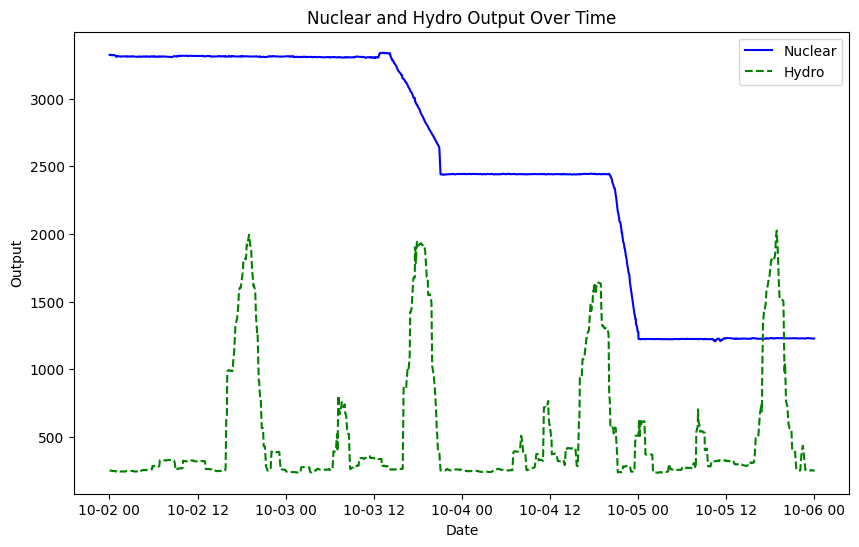

In [11]:
# Set 'BeginDate' as the index for easier plotting
real_data.set_index('BeginDate', inplace=True)

# Plot 'Nuclear' and 'Hydro' as a function of time
plt.figure(figsize=(10, 6))
plt.plot(real_data.index, real_data['Nuclear'], label='Nuclear', color='blue', linestyle='-')
plt.plot(real_data.index, real_data['Hydro'], label='Hydro', color='green', linestyle='--')

# Add title and labels
plt.title('Nuclear and Hydro Output Over Time')
plt.xlabel('Date')
plt.ylabel('Output')

# Add legend
plt.legend()

# Display the plot
plt.show()

ValueError: x and y must have same first dimension, but have shapes (864,) and (3,)

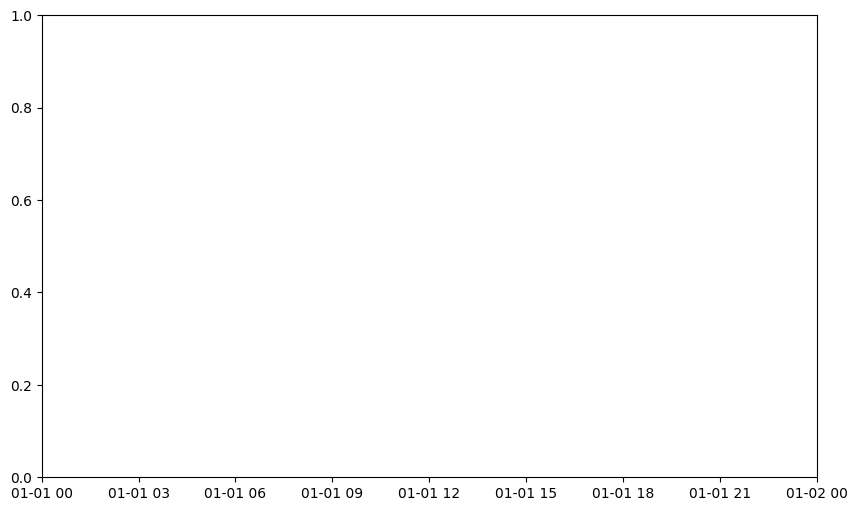

In [12]:
# Plot predictions
plt.figure(figsize=(10, 6))

# Plot y_pred_hydro (predicted hydro output)
plt.plot(test_data_with_renewables['BeginDate'], y_pred_hydro, label='Predicted Hydro', color='green', linestyle='--')

# Plot y_pred_nuke (predicted nuclear output)
plt.plot(test_data_with_renewables['BeginDate'], y_pred_nuke, label='Predicted Nuclear', color='blue', linestyle='-')

# Add title and labels
plt.title('Predicted Hydro and Nuclear Output Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Output')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [1]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Ensure both 'BeginDate' columns are timezone-naive
test_data_with_renewables['BeginDate'] = pd.to_datetime(test_data_with_renewables['BeginDate']).dt.tz_localize(None)
real_data['BeginDate'] = pd.to_datetime(real_data['BeginDate']).dt.tz_localize(None)

# Merge data on BeginDate to align actual and predicted data
merged_data = pd.merge(test_data_with_renewables[['BeginDate']], real_data[['BeginDate', 'Hydro', 'Nuclear']], on='BeginDate', how='inner')

# Align the predictions with the merged data
y_pred_hydro = y_pred_hydro[:len(merged_data)]
y_pred_nuke = y_pred_nuke[:len(merged_data)]

# Actual values from real_data
actual_hydro = merged_data['Hydro']
actual_nuke = merged_data['Nuclear']

# Calculate RMSE and R² for Hydro predictions
rmse_hydro = np.sqrt(mean_squared_error(actual_hydro, y_pred_hydro))
r2_hydro = r2_score(actual_hydro, y_pred_hydro)

# Calculate RMSE and R² for Nuclear predictions
rmse_nuke = np.sqrt(mean_squared_error(actual_nuke, y_pred_nuke))
r2_nuke = r2_score(actual_nuke, y_pred_nuke)

# Print the results
print(f'RMSE for Hydro predictions: {rmse_hydro}')
print(f'R² for Hydro predictions: {r2_hydro}')

print(f'RMSE for Nuclear predictions: {rmse_nuke}')
print(f'R² for Nuclear predictions: {r2_nuke}')

NameError: name 'pd' is not defined